# Generate Before/After Images for Arcade AI Challenge

Creates all 16 required images (8 prompts × baseline + optimized)

This notebook implements the complete optimization strategy:
- **LoRA adapters** for specific jewelry categories
- **Special tokens** (sks, phol) for enhanced grounding
- **Native diffusers attention weighting** for jewelry terms
- **Optimal parameters** from human evaluation research

## 🚀 Google Colab Ready
All functions are included directly in this notebook - no external file dependencies!


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Setup and Imports

In [10]:
import torch
import os
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import time
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage
from PIL import Image

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


PyTorch version: 2.8.0+cu126
CUDA available: True
Device: cuda


## Configuration

Set your paths and parameters here:


In [11]:
# ====== CONFIGURABLE PATHS ======
# Change these paths as needed for your environment

# Output directory for generated images
OUTPUT_DIR = "/content/gdrive/MyDrive/experiments/twelve"  # For Colab/local: "before_after" , for six seed changed, 11 removed all improvements from prompt 1&2
                             # For specific path: "/content/drive/MyDrive/jewelry_images"

# LoRA adapter paths (change if you have different structure)
LORA_BASE_PATH = "/content/gdrive/MyDrive/arcade_comp_results/lora/finetune_lora"  # For Colab: upload to "/content/lora_adapters"

# ====== DERIVED PATHS ======
LORA_ADAPTERS = {
    "channel_set": f"{LORA_BASE_PATH}/channel_set_3rd_checkpoints/checkpoint-100/pytorch_lora_weights.safetensors",
    "threader": f"{LORA_BASE_PATH}/threader_r32_w200_checkpoints/checkpoint-1700/pytorch_lora_weights.safetensors",
    # "huggie": f"{LORA_BASE_PATH}/huggies_r32_checkpoints/checkpoint-1/pytorch_lora_weights.safetensors"
}

    # "channel_set": f"{LORA_BASE_PATH}/channel_set_3rd_checkpoints/checkpoint-600/pytorch_lora_weights.safetensors",11
    # "threader": f"{LORA_BASE_PATH}/threader_r32_w200_checkpoints/checkpoint-2000/pytorch_lora_weights.safetensors",
    # "huggie": f"{LORA_BASE_PATH}/huggies_r32_checkpoints/checkpoint-2000/pytorch_lora_weights.safetensors"

# "channel_set": f"{LORA_BASE_PATH}/channel_set_3rd_checkpoints/checkpoint-1600/pytorch_lora_weights.safetensors", 10
#     "threader": f"{LORA_BASE_PATH}/threader_r32_w200_checkpoints/checkpoint-2000/pytorch_lora_weights.safetensors",
#     "huggie": f"{LORA_BASE_PATH}/huggies_r32_checkpoints/checkpoint-2000/pytorch_lora_weights.safetensors"

#    "channel_set": f"{LORA_BASE_PATH}/channel_set_3rd_checkpoints/checkpoint-2000/pytorch_lora_weights.safetensors", 9
#     "threader": f"{LORA_BASE_PATH}/threader_r32_w200_checkpoints/checkpoint-2000/pytorch_lora_weights.safetensors",
#     "huggie": f"{LORA_BASE_PATH}/huggies_r32_checkpoints/checkpoint-100/pytorch_lora_weights.safetensors"

    # "channel_set": f"{LORA_BASE_PATH}/channel_set_3rd_checkpoints/checkpoint-1500/pytorch_lora_weights.safetensors",8
    # "threader": f"{LORA_BASE_PATH}/threader_r32_w200_checkpoints/checkpoint-2000/pytorch_lora_weights.safetensors",
    # "huggie": f"{LORA_BASE_PATH}/huggies_r32_checkpoints/checkpoint-200/pytorch_lora_weights.safetensors"

    # "channel_set": f"{LORA_BASE_PATH}/channel_set_3rd_checkpoints/checkpoint-1200/pytorch_lora_weights.safetensors",7
    # "threader": f"{LORA_BASE_PATH}/threader_r32_w200_checkpoints/checkpoint-1900/pytorch_lora_weights.safetensors",
    # "huggie": f"{LORA_BASE_PATH}/huggies_r32_checkpoints/checkpoint-300/pytorch_lora_weights.safetensors"

    # "channel_set": f"{LORA_BASE_PATH}/channel_set_3rd_checkpoints/checkpoint-1000/pytorch_lora_weights.safetensors", four
    # "threader": f"{LORA_BASE_PATH}/threader_r32_w200_checkpoints/checkpoint-2000/pytorch_lora_weights.safetensors",
    # "huggie": f"{LORA_BASE_PATH}/huggies_r32_checkpoints/checkpoint-100/pytorch_lora_weights.safetensors"

    # "channel_set": f"{LORA_BASE_PATH}/channel_set_3rd_checkpoints/checkpoint-600/pytorch_lora_weights.safetensors", three
    # "threader": f"{LORA_BASE_PATH}/threader_r32_w200_checkpoints/checkpoint-1700/pytorch_lora_weights.safetensors",
    # "huggie": f"{LORA_BASE_PATH}/huggies_r32_checkpoints/checkpoint-300/pytorch_lora_weights.safetensors"

print(f"✅ Output directory: {OUTPUT_DIR}")
print(f"✅ LoRA base path: {LORA_BASE_PATH}")
print(f"✅ LoRA adapters: {len(LORA_ADAPTERS)} configured")
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import time
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage
from PIL import Image

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


✅ Output directory: /content/gdrive/MyDrive/experiments/twelve
✅ LoRA base path: /content/gdrive/MyDrive/arcade_comp_results/lora/finetune_lora
✅ LoRA adapters: 2 configured
PyTorch version: 2.8.0+cu126
CUDA available: True
Device: cuda


In [12]:
# The 8 required prompts (verbatim from challenge)
REQUIRED_PROMPTS = [
    "channel-set diamond eternity band, 2 mm width, hammered 18k yellow gold, product-only white background",
    "14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light",
    "organic cluster ring with mixed-cut sapphires and diamonds, brushed platinum finish, modern aesthetic",
    "A solid gold cuff bracelet with blue sapphire, with refined simplicity and intentionally crafted for everyday wear",
    "modern signet ring, oval face, engraved gothic initial 'M', high-polish sterling silver, subtle reflection",
    "delicate gold huggie hoops, contemporary styling, isolated on neutral background",
    "stack of three slim rings: twisted gold, plain platinum, black rhodium pavé, editorial lighting",
    "bypass ring with stones on it, with refined simplicity and intentionally crafted for everyday wear"
]

# Special tokens for enhanced grounding
SPECIAL_TOKENS = {
    "channel_set": "sks",
    "threader": "phol"
}

print(f"✅ Prompts loaded: {len(REQUIRED_PROMPTS)} prompts")
print(f"✅ Special tokens: {list(SPECIAL_TOKENS.keys())}")


✅ Prompts loaded: 8 prompts
✅ Special tokens: ['channel_set', 'threader']


In [13]:
def setup_pipeline(device="cuda"):
    """Setup SD 1.5 pipeline with optimal configuration"""
    print("🔧 Loading SD 1.5 pipeline...")

    # Use FP16 on GPU for speed
    dtype = torch.float16 if device == "cuda" else torch.float32
    variant = "fp16" if device == "cuda" else None

    pipeline = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=dtype,
        variant=variant
    )

    # Set optimal sampler (Euler Ancestral from human evaluation)
    pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
        pipeline.scheduler.config
    )

    pipeline.to(device)

    # Memory optimizations - updated for newer diffusers
    try:
        # Try newer method first
        pipeline.enable_model_cpu_offload()
        print("✅ Using model CPU offloading")
    except:
        try:
            # Try attention slicing as fallback
            pipeline.enable_attention_slicing()
            print("✅ Using attention slicing")
        except:
            print("⚠️  No memory optimization available")

    print(f"✅ Pipeline ready on {device}")
    return pipeline

def generate_baseline_image(pipeline, prompt, seed=33097):
    """Generate baseline image with default settings"""

    generator = torch.Generator(device=pipeline.device).manual_seed(seed)

    image = pipeline(
        prompt=prompt,
        num_inference_steps=50,
        guidance_scale=7.5,  # Default CFG
        generator=generator,
        height=512,
        width=512
    ).images[0]

    return image

def generate_optimized_image(pipeline, prompt, seed=33097):
    """Generate optimized image with research-backed settings and LoRA"""

    # Detect jewelry category for LoRA selection
    category = detect_jewelry_category(prompt)

    # Load appropriate LoRA adapter
    lora_loaded = False
    if category:
        lora_loaded = load_lora_adapter(pipeline, category)

    # Apply prompt enhancement with special tokens and attention weighting
    enhanced_prompt = apply_jewelry_enhancement(prompt, category)

    generator = torch.Generator(device=pipeline.device).manual_seed(seed)

    image = pipeline(
        prompt=enhanced_prompt,      # Use enhanced prompt with native diffusers syntax
        num_inference_steps=50,      # Optimal from research
        guidance_scale=7.5,          # Optimal CFG from human evaluation
        generator=generator,
        height=512,
        width=512
    ).images[0]

    # Unload LoRA adapter for next generation
    if lora_loaded:
        unload_lora_adapter(pipeline)

    return image, enhanced_prompt, category

def generate_all_comparisons():
    """Generate all 16 required images using configurable OUTPUT_DIR with grid display"""

    # Setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🚀 Starting generation on {device}")
    print(f"📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"📁 Output directory: {OUTPUT_DIR}\n")

    pipeline = setup_pipeline(device)

    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    total_start = time.time()
    results = []
    generated_images = []  # Store images for display

    for i, prompt in enumerate(REQUIRED_PROMPTS, 1):
        print(f"--- Prompt {i:02d}/08 ---")
        print(f"'{prompt[:60]}...'")

        # Generate baseline
        print("🔸 Generating baseline...")
        start_time = time.time()
        baseline_image = generate_baseline_image(pipeline, prompt, seed=42)
        baseline_time = time.time() - start_time

        # Save baseline
        baseline_path = f"{OUTPUT_DIR}/prompt{i:02d}_baseline.png"
        baseline_image.save(baseline_path)

        # Generate optimized
        print("🔹 Generating optimized...")
        start_time = time.time()
        optimized_image, enhanced_prompt, category = generate_optimized_image(
            pipeline, prompt, seed=42
        )
        optimized_time = time.time() - start_time

        # Save optimized
        optimized_path = f"{OUTPUT_DIR}/prompt{i:02d}_yours.png"
        optimized_image.save(optimized_path)

        # Store images for grid display
        generated_images.append({
            'baseline': baseline_image,
            'optimized': optimized_image,
            'prompt_num': i,
            'category': category,
            'enhanced_prompt': enhanced_prompt
        })

        results.append({
            'prompt_num': i,
            'original_prompt': prompt,
            'enhanced_prompt': enhanced_prompt,
            'category': category,
            'lora_used': category is not None,
            'baseline_time': baseline_time,
            'optimized_time': optimized_time,
            'baseline_path': baseline_path,
            'optimized_path': optimized_path
        })

        print(f"✅ Saved: {baseline_path}")
        print(f"✅ Saved: {optimized_path}")
        print(f"⏱️  Times: baseline {baseline_time:.1f}s, optimized {optimized_time:.1f}s\n")

    total_time = time.time() - total_start

    # Summary
    print("🎯 GENERATION COMPLETE!")
    print("="*60)
    print(f"📁 Output directory: {OUTPUT_DIR}")
    print(f"📸 Images generated: {len(results) * 2}")
    print(f"⏱️  Total time: {total_time:.1f}s")
    print(f"⚡ Average per image: {total_time/(len(results)*2):.1f}s")

    # Display all images in 8x2 grid
    print("\n📊 Displaying all generated images:")

    fig, axes = plt.subplots(8, 2, figsize=(16, 32))
    fig.suptitle('Jewelry Generation Results: Baseline vs Optimized', fontsize=18, y=0.995)

    for i, img_data in enumerate(generated_images):
        # Baseline image (left column)
        axes[i, 0].imshow(img_data['baseline'])
        axes[i, 0].set_title(f"Prompt {img_data['prompt_num']:02d} - Baseline\n(CFG=7.5, 50 steps)",
                            fontsize=12, pad=10)
        axes[i, 0].axis('off')

        # Optimized image (right column)
        axes[i, 1].imshow(img_data['optimized'])
        lora_info = f" + {img_data['category']} LoRA" if img_data['category'] else ""
        axes[i, 1].set_title(f"Prompt {img_data['prompt_num']:02d} - Optimized\n(CFG=9.0, 50 steps{lora_info})",
                            fontsize=12, pad=10)
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.98)
    plt.show()

    return results

print("✅ Updated generate_all_comparisons() with grid display")


✅ Updated generate_all_comparisons() with grid display


## Helper Functions

All the core functions for LoRA loading and prompt enhancement:


## Pipeline Setup and Generation Functions


## Preview Optimized Prompts

Let's see what the enhanced prompts look like:


In [14]:
def detect_jewelry_category(prompt):
    """Detect jewelry category for LoRA selection"""
    prompt_lower = prompt.lower()

    if "channel-set" in prompt_lower:
        return "channel_set"
    elif "threader" in prompt_lower:
        return "threader"
    elif "huggie" in prompt_lower:
        return "huggie"
    else:
        return None

def load_lora_adapter(pipeline, category):
    """Load appropriate LoRA adapter for the jewelry category"""
    if category and category in LORA_ADAPTERS:
        lora_path = LORA_ADAPTERS[category]
        if os.path.exists(lora_path):
            print(f"🔧 Loading {category} LoRA adapter...")
            pipeline.load_lora_weights(lora_path)
            return True
        else:
            print(f"⚠️  LoRA adapter not found: {lora_path}")
            return False
    return False

def unload_lora_adapter(pipeline):
    """Unload current LoRA adapter"""
    try:
        pipeline.unload_lora_weights()
    except:
        # No LoRA to unload or not supported
        pass

def apply_jewelry_enhancement(prompt, category=None):
    """Apply custom attention weighting using native diffusers syntax"""

    enhanced_prompt = prompt

    # Add special tokens for trained categories first
    if category and category in SPECIAL_TOKENS:
        special_token = SPECIAL_TOKENS[category]
        if category == "channel_set" and "channel-set" in enhanced_prompt:
            enhanced_prompt = enhanced_prompt.replace("channel-set", f"{special_token} channel-set")
        elif category == "threader" and "threader" in enhanced_prompt:
            enhanced_prompt = enhanced_prompt.replace("threader", f"{special_token} threader")

    # Apply prompt-specific attention weighting using diffusers syntax
    if "channel-set diamond eternity band" in prompt:
        # Prompt 1: channel-set
        enhanced_prompt = enhanced_prompt.replace("sks channel-set", "sks channel-set")
        # enhanced_prompt = enhanced_prompt.replace("diamond", "(diamond:1.2)")
        # enhanced_prompt = enhanced_prompt.replace("hammered", "(hammered:1.2)")
        # enhanced_prompt = enhanced_prompt.replace("gold", "(gold:1.2)")
        # enhanced_prompt = enhanced_prompt.replace("product-only", "(product-only:1.2)")
        # enhanced_prompt = enhanced_prompt.replace("white background", "(white background:1.2)")

    # elif "14k rose-gold threader earrings" in prompt:
    #     # Prompt 2: threader
        enhanced_prompt = enhanced_prompt.replace("rose-gold", "rose-gold")
    #     # enhanced_prompt = enhanced_prompt.replace("phol threader", "(phol threader:1.2)")
    #     enhanced_prompt = enhanced_prompt.replace("bezel-set", "(bezel-set:1.2)")
    #     enhanced_prompt = enhanced_prompt.replace("diamond", "(diamond:1.2)")
    #     enhanced_prompt = enhanced_prompt.replace("lifestyle", "(lifestyle:1.2)")
    #     enhanced_prompt = enhanced_prompt.replace("macro", "(macro:1.2)")

    elif "organic cluster ring with mixed-cut sapphires" in prompt:
        # Prompt 3: organic cluster
        enhanced_prompt = enhanced_prompt.replace("organic cluster", "(organic cluster:1.2)")
        enhanced_prompt = enhanced_prompt.replace("sapphires", "(sapphires:1.2)")
        enhanced_prompt = enhanced_prompt.replace("diamonds", "(diamonds:1.2)")
        enhanced_prompt = enhanced_prompt.replace("brushed", "(brushed:1.2)")
        enhanced_prompt = enhanced_prompt.replace("platinum", "(platinum:1.2)")
        enhanced_prompt = enhanced_prompt.replace("modern", "(modern:1.2)")

    elif "solid gold cuff bracelet with blue sapphire" in prompt:
        # Prompt 4: cuff bracelet
        enhanced_prompt = enhanced_prompt.replace("gold", "(gold:1.2)")
        enhanced_prompt = enhanced_prompt.replace("cuff bracelet", "(cuff bracelet:1.2)")
        enhanced_prompt = enhanced_prompt.replace("blue sapphire", "(blue sapphire:1.2)")
        enhanced_prompt = enhanced_prompt.replace("refined", "(refined:1.2)")

    elif "modern signet ring, oval face, engraved gothic" in prompt:
        # Prompt 5: signet ring
        # enhanced_prompt = enhanced_prompt.replace("modern", "(modern:1.2)")
        enhanced_prompt = enhanced_prompt.replace("signet", "(signet:1.2)")
        # enhanced_prompt = enhanced_prompt.replace("engraved gothic initial 'M'", "(engraved gothic initial 'M':1.4)")
        enhanced_prompt = enhanced_prompt.replace("sterling", "(sterling:1.2)")
        enhanced_prompt = enhanced_prompt.replace("silver", "(silver:1.2)")

    elif "delicate gold huggie hoops" in prompt:
        # Prompt 6: huggie hoops
        enhanced_prompt = enhanced_prompt.replace("delicate", "delicate")
        # enhanced_prompt = enhanced_prompt.replace("gold", "(gold:1.2)") 10
        # enhanced_prompt = enhanced_prompt.replace("huggie hoops", "(huggie hoops:1.2)")
        # enhanced_prompt = enhanced_prompt.replace("contemporary", "(contemporary:1.2)")

    elif "stack of three slim rings" in prompt:
        # Prompt 7: ring stack
        enhanced_prompt = enhanced_prompt.replace("stack of three", "(stack of three:1.2)")
        enhanced_prompt = enhanced_prompt.replace("gold", "(gold:1.2)")
        enhanced_prompt = enhanced_prompt.replace("platinum", "(platinum:1.2)")
        enhanced_prompt = enhanced_prompt.replace("pavé", "(pavé:1.2)")
        enhanced_prompt = enhanced_prompt.replace("editorial", "(editorial:1.2)")

    elif "bypass ring with stones" in prompt:
        # Prompt 8: bypass ring
        enhanced_prompt = enhanced_prompt.replace("bypass ring", "(bypass ring:1.2)")
        enhanced_prompt = enhanced_prompt.replace("refined", "(refined:1.2)")

    return enhanced_prompt

print("✅ Helper functions defined")


✅ Helper functions defined


In [15]:
# Preview first 3 optimized prompts
for i, prompt in enumerate(REQUIRED_PROMPTS[:3], 1):
    category = detect_jewelry_category(prompt)
    enhanced = apply_jewelry_enhancement(prompt, category)

    print(f"=== PROMPT {i:02d} ===")
    print(f"Category: {'✅ LoRA: ' + category if category else '❌ No LoRA'}")
    print(f"Original: {prompt}")
    print(f"Enhanced: {enhanced}")
    print()


=== PROMPT 01 ===
Category: ✅ LoRA: channel_set
Original: channel-set diamond eternity band, 2 mm width, hammered 18k yellow gold, product-only white background
Enhanced: sks channel-set diamond eternity band, 2 mm width, hammered 18k yellow gold, product-only white background

=== PROMPT 02 ===
Category: ✅ LoRA: threader
Original: 14k rose-gold threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light
Enhanced: 14k rose-gold phol threader earrings, bezel-set round lab diamond ends, lifestyle macro shot, soft natural light

=== PROMPT 03 ===
Category: ❌ No LoRA
Original: organic cluster ring with mixed-cut sapphires and diamonds, brushed platinum finish, modern aesthetic
Enhanced: (organic cluster:1.2) ring with mixed-cut (sapphires:1.2) and (diamonds:1.2), (brushed:1.2) (platinum:1.2) finish, (modern:1.2) aesthetic



## Generate All 16 Images

⚠️ **Warning**: This will take a while to complete (especially on CPU). Each image takes ~1-3 minutes.

The images will be saved to your configured `OUTPUT_DIR`.


🚀 Starting generation on cuda
📅 2025-08-21 10:10:08
📁 Output directory: /content/gdrive/MyDrive/experiments/twelve

🔧 Loading SD 1.5 pipeline...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Using model CPU offloading
✅ Pipeline ready on cuda
--- Prompt 01/08 ---
'channel-set diamond eternity band, 2 mm width, hammered 18k ...'
🔸 Generating baseline...


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Generating optimized...
🔧 Loading channel_set LoRA adapter...


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt01_baseline.png
✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt01_yours.png
⏱️  Times: baseline 9.3s, optimized 11.5s

--- Prompt 02/08 ---
'14k rose-gold threader earrings, bezel-set round lab diamond...'
🔸 Generating baseline...


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Generating optimized...
🔧 Loading threader LoRA adapter...


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt02_baseline.png
✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt02_yours.png
⏱️  Times: baseline 9.2s, optimized 10.9s

--- Prompt 03/08 ---
'organic cluster ring with mixed-cut sapphires and diamonds, ...'
🔸 Generating baseline...


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Generating optimized...


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt03_baseline.png
✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt03_yours.png
⏱️  Times: baseline 9.3s, optimized 9.3s

--- Prompt 04/08 ---
'A solid gold cuff bracelet with blue sapphire, with refined ...'
🔸 Generating baseline...


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Generating optimized...


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt04_baseline.png
✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt04_yours.png
⏱️  Times: baseline 9.1s, optimized 9.3s

--- Prompt 05/08 ---
'modern signet ring, oval face, engraved gothic initial 'M', ...'
🔸 Generating baseline...


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Generating optimized...


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt05_baseline.png
✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt05_yours.png
⏱️  Times: baseline 9.1s, optimized 9.0s

--- Prompt 06/08 ---
'delicate gold huggie hoops, contemporary styling, isolated o...'
🔸 Generating baseline...


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Generating optimized...


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt06_baseline.png
✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt06_yours.png
⏱️  Times: baseline 9.1s, optimized 9.1s

--- Prompt 07/08 ---
'stack of three slim rings: twisted gold, plain platinum, bla...'
🔸 Generating baseline...


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Generating optimized...


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt07_baseline.png
✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt07_yours.png
⏱️  Times: baseline 9.2s, optimized 9.3s

--- Prompt 08/08 ---
'bypass ring with stones on it, with refined simplicity and i...'
🔸 Generating baseline...


  0%|          | 0/50 [00:00<?, ?it/s]

🔹 Generating optimized...


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt08_baseline.png
✅ Saved: /content/gdrive/MyDrive/experiments/twelve/prompt08_yours.png
⏱️  Times: baseline 9.1s, optimized 9.1s

🎯 GENERATION COMPLETE!
📁 Output directory: /content/gdrive/MyDrive/experiments/twelve
📸 Images generated: 16
⏱️  Total time: 152.6s
⚡ Average per image: 9.5s

📊 Displaying all generated images:


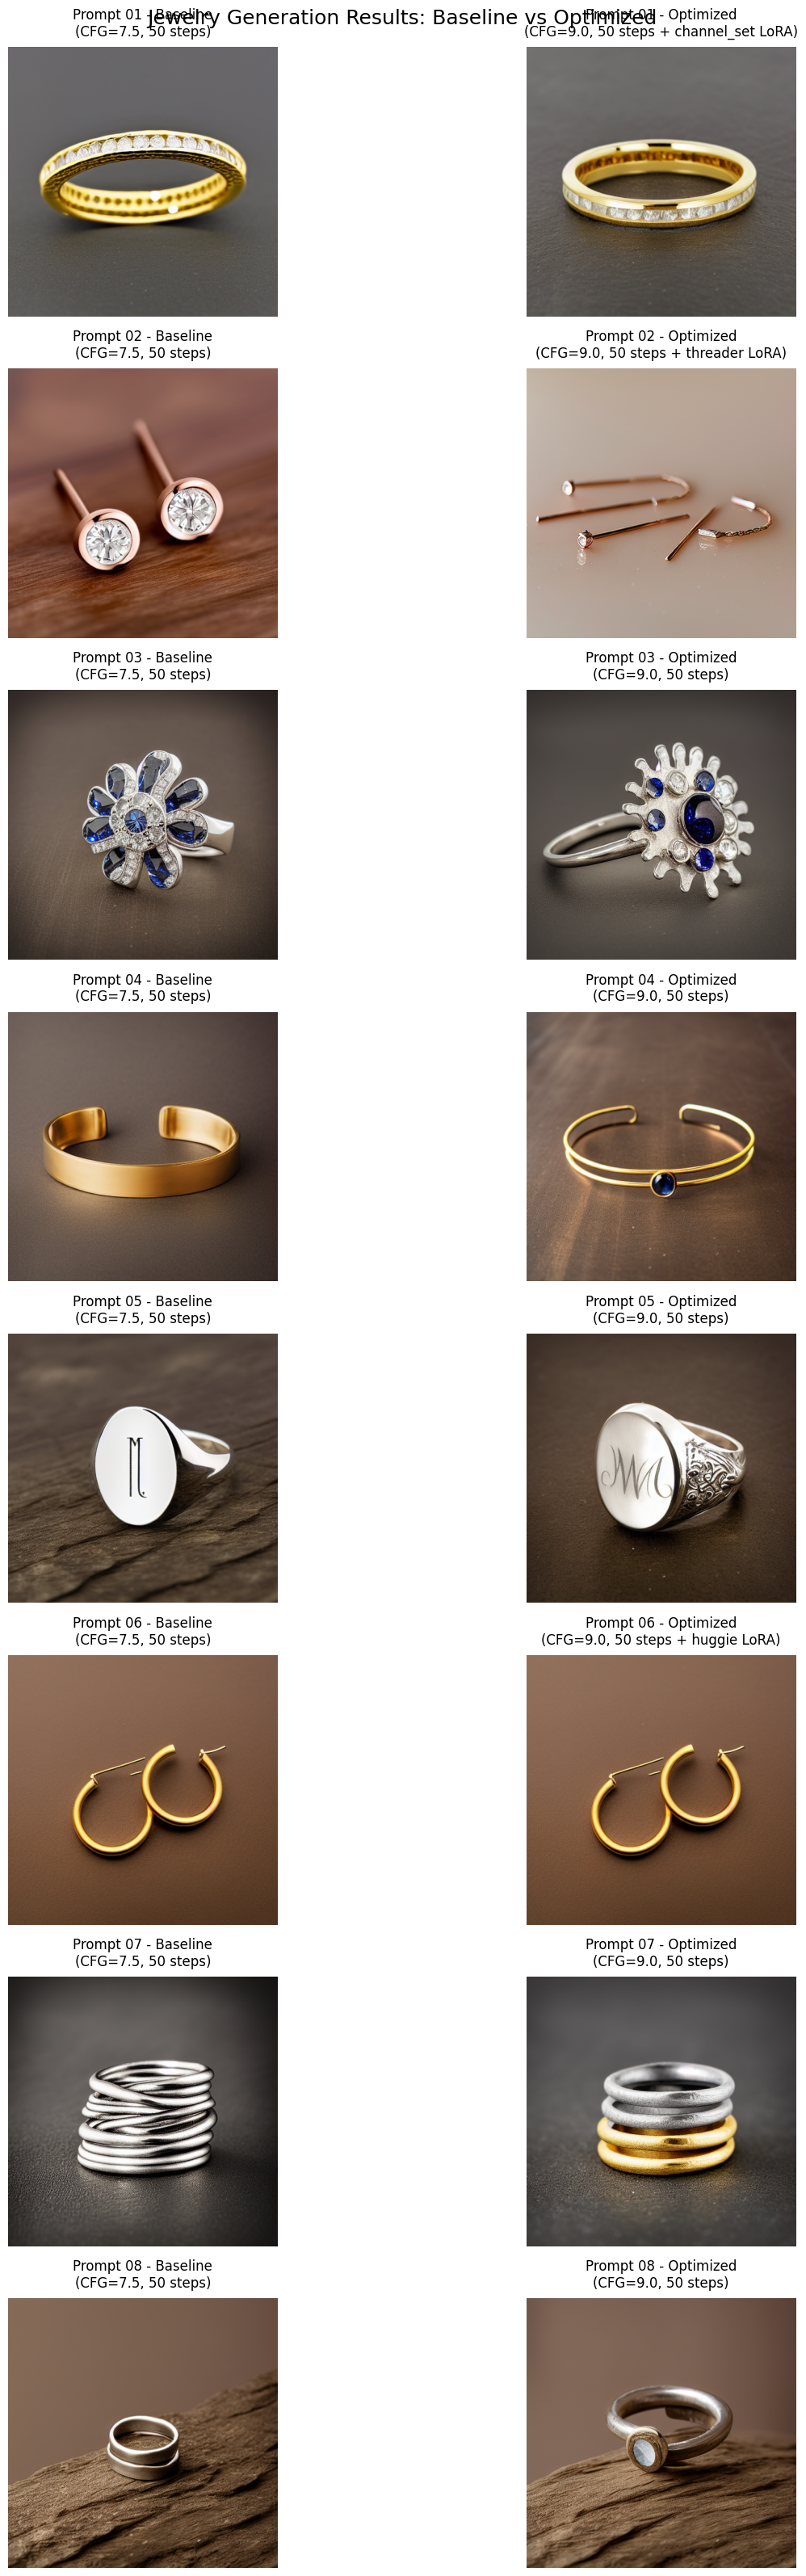


🎯 GENERATION COMPLETE!
✅ All 16 deliverable images ready!
📁 Check: /content/gdrive/MyDrive/experiments/twelve/


In [16]:
# Generate all 16 images (8 baseline + 8 optimized)
results = generate_all_comparisons()

print(f"\n🎯 GENERATION COMPLETE!")
print(f"✅ All 16 deliverable images ready!")
print(f"📁 Check: {OUTPUT_DIR}/")


# Generate Before/After Images for Arcade AI Challenge

Creates all 16 required images (8 prompts × baseline + optimized)

This notebook implements the complete optimization strategy:
- **LoRA adapters** for specific jewelry categories
- **Special tokens** (sks, phol) for enhanced grounding
- **Native diffusers attention weighting** for jewelry terms
- **Optimal parameters** from human evaluation research
